## Code Implementation

Some information on Decision Forests and Gradient Boosted Trees: 

 - Decision Forests are a family of algorithms built from many decision trees
 - TensorFlow Decision Forests allow us to train Random Forest or Gradient Boosted Trees using the familiar TensorFlow API.
 - Gradient Boosted Trees combines weak learners (usually decision trees with only one split, called decision stumps) sequentially, so that each new tree corrects the errors of the previous one. 

For the implementation part of the Decision Forest model, we will train a Gradient Boosted Trees model on the tabular 'dfDatabase.csv' file. The objective is to determine if a certain area/pixel is attributed as an Area-of-Concern for different reasons. The dataset contains numerical features and the model is designed as a classification model type.

### 1. Gradient Boosted Trees Model
We begin by importing all the necessary libraries:

In [1]:
# Importing all the dependencies
import datetime, os, shutil, gc, math, warnings
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle
from matplotlib import colors as c
from mycolorpy import colorlist as mcp
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_decision_forests as tfdf
import keras
import keras_tuner
from keras import Input, Model
from keras.utils import plot_model
from keras.layers import Dense,Flatten,Reshape,Concatenate,Add,Multiply,Lambda,BatchNormalization,Activation,Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler,TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import Image, IFrame

2023-08-29 20:25:48.534049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 20:25:49.499791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Reading the data from the .csv file
dfData = pd.read_csv('./ms_osm_buildings_syria_fix_sf_32637_training_v3.csv')
gc.collect()
dfData.head(5)

,id,area,perimeter,norm_shape_index,n_vertices,Keep,width,height,wh_ratio,GHS_POP_2020,WorldPOP_2020_UNadj_constrained,EOG_NTL_2023_03,GLAD_2019_cropland,GLCLU_2020,ESA_2021,OSM_RoadDensity
0,13,14.152117,15.059647,0.784155,5,1,3.824436,3.965743,0.964368,0.006431,0.019631,1.0,0.370582,250,30,84.514374
1,17,64.501318,34.585155,0.677640,5,1,5.447710,11.848945,0.459763,0.046194,0.095135,1.0,0.000000,250,50,0.000000
2,34,48.662439,28.971631,0.728547,5,1,5.298423,9.196961,0.576106,0.795359,0.252097,18.0,0.000000,250,50,262.496552
3,132,17.161322,17.117221,0.736028,5,1,3.480963,5.418265,0.642450,0.088728,0.067500,1.0,0.000000,250,50,84.613380
4,143,317.258561,100.326332,0.396090,5,0,7.424374,42.941203,0.172896,0.000000,0.000000,0.0,0.000000,122,40,0.000000


## Defining the pipeline of the model

In [3]:
# Defining a function to help plotting the results
def plot_tfdf_model_training_curves(model):
    # This function was adapted from the following tutorial:
    # https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
    logs = model.make_inspector().training_logs()
    plt.figure(figsize=(12, 4))
    # Plot accuracy vs number of trees
    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel('Number of trees')
    plt.ylabel('Accuracy (out-of-bag)')
    # Plot loss vs number of trees
    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel('Number of trees')
    plt.ylabel('Logloss (out-of-bag)')
    # Show the plot
    plt.show()

def plot_tfdf_confusion_matrix(obsv_data, pred_data, labels=None):
    # Computing the confusion matrix
    cm = confusion_matrix(obsv_data, pred_data)
    # Displaying the confusion matrix
    cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cm_plt.plot(cmap=plt.cm.Blues)
    return(cm_plt)

def run_experiment(model, train_data, test_data, target_column_name, weight_column_name=None, class_weight=None, num_epochs=1, plots=False):
    # Defining the training and test datasets
    train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=target_column_name, weight=weight_column_name)
    test_dataset  = tfdf.keras.pd_dataframe_to_tf_dataset(test_data,  label=target_column_name, weight=weight_column_name)
    # Training the model
    model.fit(train_dataset, class_weight=class_weight, epochs=num_epochs, verbose=0)
    # Showing the results
    _, acc, acc_wgt = model.evaluate(train_dataset, verbose=0); 
    print(f'Train accuracy: {round(acc*100,2)}% \t| Train weighted_accuracy: {round(acc_wgt*100,2)}%')
    _, acc, acc_wgt = model.evaluate(test_dataset,  verbose=0); 
    print(f'Test accuracy:  {round(acc*100,2)}% \t| Test weighted_accuracy:  {round(acc_wgt*100,2)}%')
    if plots==True:
        # Plotting the Accuracy and Logloss
        plot_tfdf_model_training_curves(model)
        # Plotting the confusion matrix
        labels = ['False','True']
        fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey='row')
        plt.subplots_adjust(right = 0.8)
        # Train test - confusion matrix
        cm = confusion_matrix(list(train_data[target_column_name]), np.round(model.predict(train_dataset,verbose=0),0))
        cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        cm_plt.plot(ax=ax[0])
        cm_plt.ax_.set_title('Train')
        # Test test - confusion matrix
        cm = confusion_matrix(list(test_data[target_column_name]), np.round(model.predict(test_dataset,verbose=0),0))
        print(f'Test False recall:  {round((cm[0,0]/np.sum(cm[0,:]))*100,2)}%')
        print(f'Test True  recall:  {round((cm[1,1]/np.sum(cm[1,:]))*100,2)}%')
        cm_plt = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        cm_plt.plot(ax=ax[1])
        cm_plt.ax_.set_title('Test')
        # Plotting the results
        plt.show()
        # Plotting the variable importance
        inspector = model.make_inspector()
        var_imp = inspector.variable_importances()["SUM_SCORE"]
        var_imp_nam = list(reversed([str(x) for x,_ in var_imp][0:10]))
        var_imp_nam = [txt.split('"')[1] for txt in var_imp_nam]
        var_imp_val = list(reversed([int(x) for _,x in var_imp][0:10]))
        var_imp_val = var_imp_val/np.sum(var_imp_val)
        plt.barh(var_imp_nam, var_imp_val)
        plt.title('Top 10 Features')
        plt.xlabel("Relative SUM_SCORE Feature Importance")
        # Plotting the results
        plt.show()

In [4]:
# Selecting the target and feature variables
tgt = ['Keep']
# Selecting the column names to be used as the feature variables
feats = [
    'area',
    'perimeter',
    'norm_shape_index',
    'width',
    'height',
    'wh_ratio',
    'n_vertices',
    'GHS_POP_2020',
    'WorldPOP_2020_UNadj_constrained',
    'EOG_NTL_2023_03',
    'GLAD_2019_cropland',
    'GLCLU_2020',
    'ESA_2021',
    'OSM_RoadDensity',
]

## Gradient Boosted Trees regression model

### Using class_weights

In [5]:
# Defining the dataset of interest
dfRun = pd.DataFrame.copy(dfData)
dfRun = dfRun[['id']+feats+tgt]
# Splitting the data into training and test sets.
X_train, X_test = train_test_split(dfRun, test_size=0.20, shuffle=True)
# Creating the results data.frame and adding the id train/test
dfRes = pd.concat([X_train,X_test])[['id']+tgt]
dfRes['idTrainTest'] = 'test'; dfRes['idTrainTest'][0:X_train.shape[0]] = 'train'
# Dropping the id column in the training and test datasets
X_train = X_train[feats+tgt]
X_test = X_test[feats+tgt]
# Computing the importance/weights of the classes
wgt = 1-X_train[tgt[0]].value_counts()/X_train[tgt[0]].shape[0]
wgt = wgt**1
wgt_norm = (wgt/max(wgt)).sort_index()
X_train[str(tgt[0]+'_wgt')] = 0
X_test[str(tgt[0]+'_wgt')] = 0
for i in range(max(wgt_norm.index)+1):
    X_train.loc[X_train[tgt[0]] == i, tgt[0]+'_wgt'] = wgt_norm[i]
    X_test.loc[X_test[tgt[0]] == i, tgt[0]+'_wgt']   = wgt_norm[i]
print('Using sample_weights: ')
print(wgt_norm)
print(X_train.shape)

Using sample_weights: 
Keep
0    1.0000
1    0.5181
Name: count, dtype: float64
(27133, 16)


/tmp/ipykernel_6629/742790811.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfRes['idTrainTest'] = 'test'; dfRes['idTrainTest'][0:X_train.shape[0]] = 'train'


2023-08-29 20:25:51.392603: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Use /tmp/tmp_3bsbojz as temporary training directory


2023-08-29 20:25:51.461605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 20:25:51.461788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-29 20:25:51.463318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Train accuracy: 97.56% 	| Train weighted_accuracy: 97.31%


2023-08-29 20:26:00.234557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [6784]
	 [[{{node Placeholder/_1}}]]


Test accuracy:  97.18% 	| Test weighted_accuracy:  96.86%


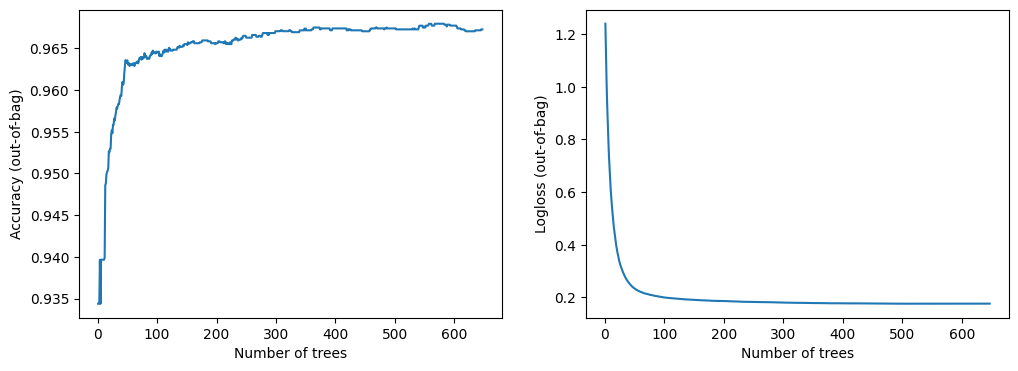

Test False recall:  95.84%
Test True  recall:  97.89%


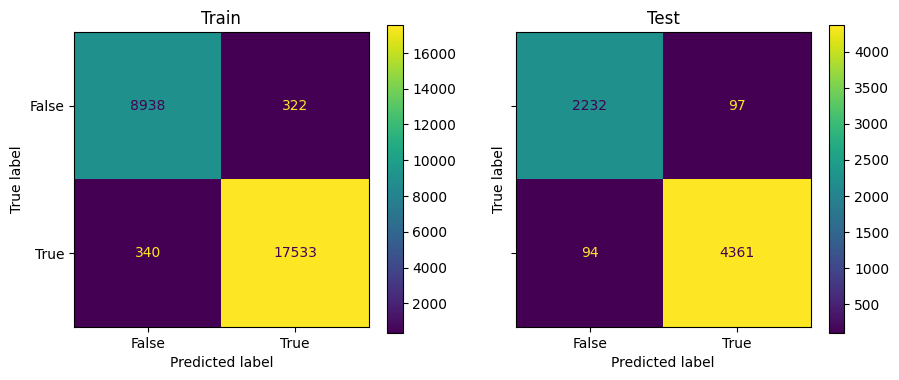

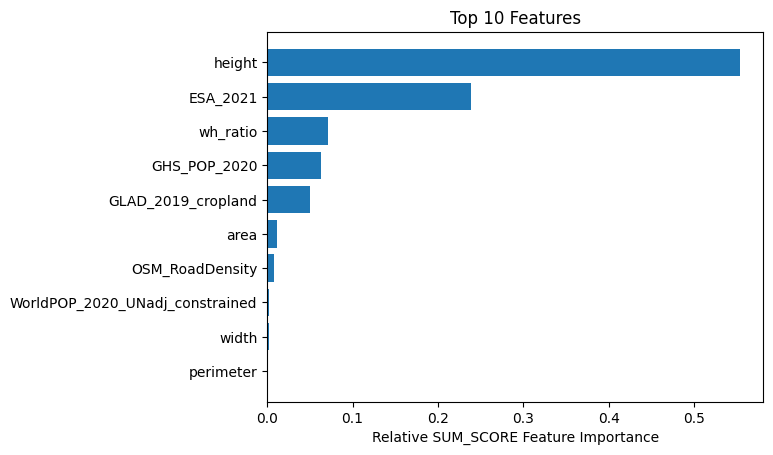

INFO:tensorflow:Assets written to: ./classifier_tfdf_gbt_targetVar.Keep/assets


INFO:tensorflow:Assets written to: ./classifier_tfdf_gbt_targetVar.Keep/assets


 9/28 [========>.....................] - ETA: 0s

2023-08-29 20:26:02.567821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [27133]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 0s 6ms/step


2023-08-29 20:26:02.797934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype double and shape [6784]
	 [[{{node Placeholder/_8}}]]


In [6]:
# Creating the features object
features = [tfdf.keras.FeatureUsage(name=feat) for feat in feats]
# Initialising and training the model
model_name = 'gbt'
model_name = str('classifier_tfdf_'+model_name+'_targetVar.'+tgt[0])
# Training the model    
model = tfdf.keras.GradientBoostedTreesModel(features=features, 
                                             exclude_non_specified_features=True,
                                             num_threads=16, 
                                             num_trees=2000,
                                             max_depth=3,
                                             min_examples=8,
                                             sampling_method='RANDOM',
                                             validation_ratio=0.25,
                                             early_stopping='LOSS_INCREASE',
                                             early_stopping_num_trees_look_ahead=100,
                                             forest_extraction='MART',
                                             growing_strategy='BEST_FIRST_GLOBAL',
                                             max_num_nodes=3, # use -1 for no limits
                                             task=tfdf.keras.Task.CLASSIFICATION,
                                             loss='BINOMIAL_LOG_LIKELIHOOD',
                                             categorical_algorithm='CART')#, 
                                             #hyperparameter_template="benchmark_rank1")
    
model.compile(metrics=keras.metrics.BinaryAccuracy(name="accuracy"), 
              weighted_metrics=keras.metrics.BinaryAccuracy(name="accuracy"))
run_experiment(model, X_train, X_test, target_column_name=tgt[0], weight_column_name=str(tgt[0]+'_wgt'), plots=True)
model.save('./'+model_name)
# Consolidating the results
train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=tgt[0], weight=str(tgt[0]+'_wgt'), task=tfdf.keras.Task.CLASSIFICATION)
test_dataset  = tfdf.keras.pd_dataframe_to_tf_dataset(X_test,  label=tgt[0], weight=str(tgt[0]+'_wgt'), task=tfdf.keras.Task.CLASSIFICATION)
pred_train = np.round(model.predict(train_dataset, verbose=1),2)
pred_test  = np.round(model.predict(test_dataset,  verbose=1),2)
# Adding the results to dfRes
dfRes[str('pred_'+tgt[0])] = np.concatenate([pred_train, pred_test], axis=0)
# Saving the results to the disk
dfRes.to_csv('./'+model_name+'/dfRes_'+tgt[0]+'.csv', index=False)

In [9]:
# Computing the results for the original data
dfDataPredict = pd.read_csv('./ms_osm_buildings_syria_fix_sf_32637_predictions_v3.csv')
run_data = pd.DataFrame.copy(dfDataPredict)
run_data = run_data[['id']+feats]
run_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(run_data, task=tfdf.keras.Task.CLASSIFICATION)
run_pred = model.predict(run_dataset, verbose=1)
df_pred = pd.DataFrame.copy(dfDataPredict)
df_pred['pred'] = run_pred
del(run_data,run_dataset,run_pred)
gc.collect()

# Saving results to .csv
df_pred.to_csv('df_predictions.csv')

 11/620 [..............................] - ETA: 3s  

2023-08-29 20:26:56.592675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype double and shape [619219]
	 [[{{node Placeholder/_12}}]]


620/620 [==============================] - 4s 6ms/step
